# Usage (details: phase setting)
Here, how to set phases in scenario analysis will be explained. As an example, use the records in India.

## Preperation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import covsirphy as cs
cs.__version__

'2.5.4-alpha.new.75'

In [3]:
# Load datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu(verbose=False)
population_data = data_loader.population(verbose=False)
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation


In [4]:
# Create instance of `Scenario` class
scenario = cs.Scenario(jhu_data, population_data, country="India", province=None)

In [5]:
# Summarize main scenario
scenario.summary()

,Type,Start,End,Population


Note:  
This is empty because no phases are registered. Term "phase" means a sequential dates in which the parameters of SIR-derived models are fixed. The details will be explained later.

Just for demonstration, we will fix the first/end date of the records here. This is un-necessary for your analysis.

In [6]:
# Fix the first date of records
scenario.first_date = "01Mar2020"
# Fix the last date of records
scenario.last_date = "20Jul2020"
# Summarize (Empty because no phases are registered)
scenario.summary()

,Type,Start,End,Population


## Set phases with S-R trend analysis
How can we set phases?

Here, we will use "S-R trend analysis" explained in [S-R trend analysis section in "Kaggle: COVID-19 data with SIR model"](https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model#S-R-trend-analysis). $S$ (Susceptible) and $R$ (Recovered) show the following relationship in SIR-derived models. $S_{(R)}$ means $S$ as a function of $R$.
$$S_{(R)} = N e^{-a R}$$
where $N$ is total population and $a=\cfrac{\beta}{N \gamma}$ is a constant.  
This leads to
$$\log S_{(R)} = - a R + \log N$$

$\log S$ decreases constantly with increase of $R$, when the records follow a SIR-derived model and the parameter values of the model are constant. With logarithmic y-axis scale, plot of $(x, y) = (R, S)$ shows a line. 

The slope of the line may change when the parameter values ($\beta$ and $\gamma$) are changed. To detect the dates when the parameter values were changed, we will find the change points of $\log S$ as a function of $R$, using [ruptures: change point detection in Python](https://github.com/deepcharles/ruptures). We call the period from a change point to the next change point as a "phase" in this analysis.

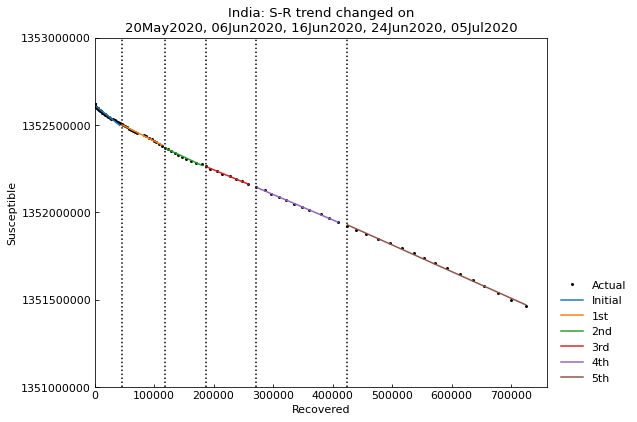

In [7]:
# Set phase with S-R trend analysis and delete initial (0th) phase
scenario.trend(set_phases=True)
# This is the same as
# scenario.trend(set_phases=True, include_init_phase=True)
# scenario.delete(phases=["0th"])

We found five change points from 01May2020 to 20Jul2020. This means that there 6 phases (Initial, 1st, 2nd,...5th). Here, we removed Initial (0th) phase because the number of cases is small in 0th phase and may not show SIR-like trend.

In [8]:
scenario.summary()

,Type,Start,End,Population
1st,Past,20May2020,05Jun2020,1352617328
2nd,Past,06Jun2020,15Jun2020,1352617328
3rd,Past,16Jun2020,23Jun2020,1352617328
4th,Past,24Jun2020,04Jul2020,1352617328
5th,Past,05Jul2020,20Jul2020,1352617328


## (Optional) Remove un-necessary change points manually
The slope of 4th seems to equal to that of 3rd phase. Here, we will combine 3rd phase and 4th phase here and reset phase names.

In [9]:
# Before: 3rd is 16Jun2020-23Jun2020, 4th is 24Jun2020-04Jul2020
# After: 3rd is 16Jun2020-04Jul2020, 4th is the same as old 5th
scenario.combine(phases=["3rd", "4th"])
scenario.summary()

,Type,Start,End,Population
1st,Past,20May2020,05Jun2020,1352617328
2nd,Past,06Jun2020,15Jun2020,1352617328
3rd,Past,16Jun2020,04Jul2020,1352617328
4th,Past,05Jul2020,20Jul2020,1352617328


Show the trend with manually set change points.

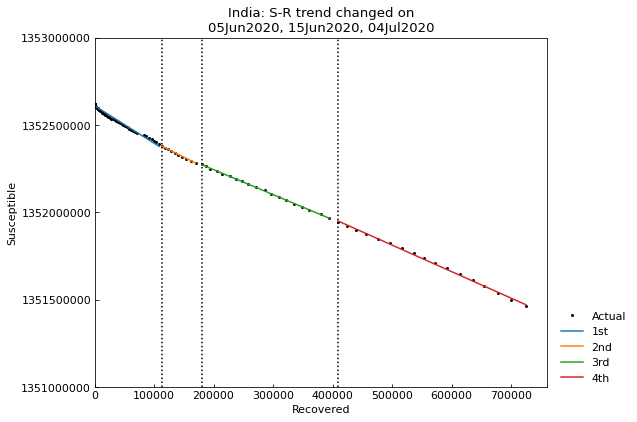

In [10]:
scenario.trend(set_phases=False)

## (Optional) Add new change points manually
Because point of $(x, y) = (S, R)$ jumped on 30May2020, we will separete the 1st phase with this change point and reset phase names.

In [11]:
# Before: 1st is 20May2020-05Jun2020
# After: 1st is 20May2020-29May2020, 2nd is 30May2020-05Jun2020
scenario.separate(date="30May2020", phase="1st")
scenario.summary()

,Type,Start,End,Population
1st,Past,20May2020,29May2020,1352617328
2nd,Past,30May2020,05Jun2020,1352617328
3rd,Past,06Jun2020,15Jun2020,1352617328
4th,Past,16Jun2020,04Jul2020,1352617328
5th,Past,05Jul2020,20Jul2020,1352617328


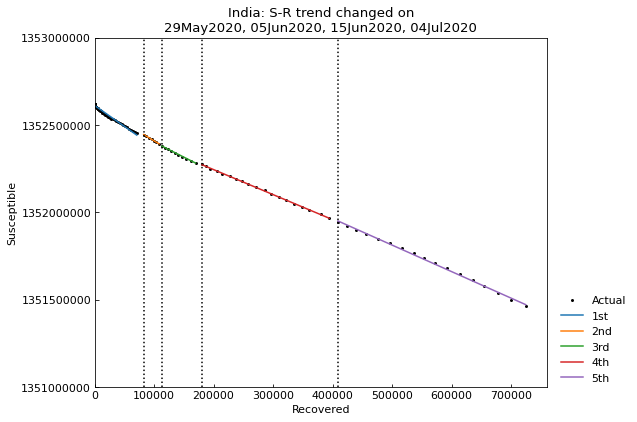

In [12]:
scenario.trend(set_phases=False)

## (Optional) Delete phases manually
Delete the 1st phase and reset the phase names.

In [14]:
# Remove 1st phase
scenario.delete(phases=["1st"])
scenario.summary()

,Type,Start,End,Population
1st,Past,30May2020,05Jun2020,1352617328
2nd,Past,06Jun2020,15Jun2020,1352617328
3rd,Past,16Jun2020,04Jul2020,1352617328
4th,Past,05Jul2020,20Jul2020,1352617328


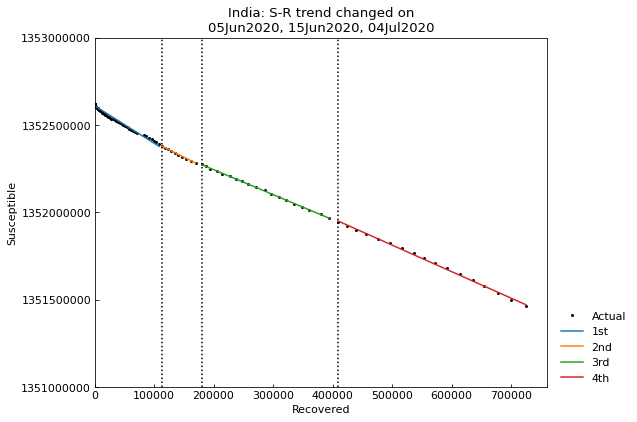

In [15]:
scenario.trend(set_phases=False)